This analisys contain a top down analysis so I decided to leave the firts analysis (diagnostic file) as separate code to see this process, on the file data_handler you could find the class data management. So thanks for reading. 

# Collision detection analysis
- Here is the Analysis of the threshold to find the closest value of the collision on the jerk in terms of to define when is produced the collision.
---

## 1. Linear Jerk
The expression for linear jerk is:
$$
j(t) = \frac{d a(t)}{dt} = \frac{d^2 v(t)}{dt^2} = \frac{d^3 r(t)}{dt^3}
$$
Where:
- $ r(t) = \begin{bmatrix} x(t) & y(t) \end{bmatrix}^{T} $ is the position vector of the robot.
- $ v(t) = \frac{dr(t)}{dt} $ is the velocity vector.
- $ a(t) = \frac{d^2 r(t)}{dt^2} $ is the acceleration vector.
- $ j(t) = \frac{d^3 r(t)}{dt^3} $ is the linear jerk vector.
## 2. Linear Jerk
The expression for rotational jerk is:
$$
\zeta(t) = \frac{d \alpha(t)}{dt} = \dot{\alpha}(t) = \ddot{\omega}(t)
$$
Where:
- $ \alpha(t) $ is the angular acceleration (rate of change of angular velocity).
- $ \omega(t) $ is the angular velocity.

## 3. Combined Jerk: Linear and Rotational
I propose a weighted jerk filter using a convex combination of linear and rotational jerk to aproach to a real collision detection:
$$
J_d = (1 - \eta) j(t) + \eta \zeta(t)
$$
Where:
- $ \eta \in [0, 1] $ is a tunable parameter to balance the contributions of linear jerk $ j(t) $ and rotational jerk $ \zeta(t) $.
- $ J_d $ is the resulting "combined jerk."

- In terms of have the same units on the both terms, we can define a new variable as:

$$\zeta_{linear}(t) = r * \zeta (t)$$

Where:
- $ r $ is the aproximation radius of the robot.
- $ \zeta_{lineat} (t) $ is the resulting of the "cicular jerk"

Disclaimer: Could be implemented other types of filter (Kalman, HansPeterLoft) in order to compare the imu camera vs imu sensor to obtain more clean data, but considering the time of reaction and the time of converge of each filter is not compatible with the requirements of the system.


# Roll over analysis
- Here is the Analysis of the threshold to find the closest value of the roll over considering the imu on the chasis of the robot.
---

# Roll, Pitch, and Yaw Analysis for Rollover Detection

To detect rollovers, we analyze the **roll**, **pitch**, and **yaw** dynamics of the robot, focusing on angular velocity and angular acceleration. These parameters are key indicators of instability or potential rollover events.

## 1. Angular Velocity
Angular velocity $\omega$ describes the rate of rotation around each axis:
$$
\omega_{\text{axis}}(t) = \frac{d\theta_{\text{axis}}(t)}{dt}
$$
Where:
- $\theta_{\text{axis}}(t) $: Angular displacement about a given axis $ x $: roll, $ y $: pitch, $ z $: yaw.
- $\omega_{\text{axis}}(t) $: Angular velocity about that axis.

Rapid changes in angular velocity, particularly in roll $ x $ and pitch $ y $ axes, may indicate instability.

## 2. Angular Acceleration
Angular acceleration $ \alpha $ is the rate of change of angular velocity:
$$
\alpha_{\text{axis}}(t) = \frac{d\omega_{\text{axis}}(t)}{dt}
$$
Where:
- $ \alpha_{\text{axis}}(t) $: Angular acceleration about a given axis.

Large angular accelerations can indicate sudden changes in the robot's orientation, which may lead to rollovers.

## 3. Combined Roll and Pitch Analysis
To detect a potential rollover, we monitor both roll $ x $ and pitch $ y $ dynamics. A threshold-based approach can be used:
- **Angular velocity threshold** $ \omega_{\text{threshold}} $:
  If $ \omega_x(t) $ or $ \omega_y(t) $ exceeds this threshold, a warning is triggered.
- **Angular acceleration threshold** $ \alpha_{\text{threshold}} $:
  If $ \alpha_x(t) $ or $ \alpha_y(t) $ exceeds this threshold, a warning is triggered.

### Expression for Threshold-Based Detection:
$$
\text{Rollover Risk} = 
\begin{cases} 
\text{True} & \text{if } |\omega_x(t)| > \omega_{\text{threshold}} \text{ or } |\alpha_x(t)| > \alpha_{\text{threshold}} \\
\text{True} & \text{if } |\omega_y(t)| > \omega_{\text{threshold}} \text{ or } |\alpha_y(t)| > \alpha_{\text{threshold}} \\
\text{False} & \text{otherwise}
\end{cases}
$$

## 4. Practical Considerations
1. **Data Smoothing**:
   To minimize noise, apply a smoothing filter (e.g., low-pass or moving average) to angular velocity and acceleration data before analysis.

2. **Calibration**:
   Set thresholds $ \omega_{\text{threshold}}, \alpha_{\text{threshold}} $ based on robot-specific dynamics and testing.

3. **Combination of Roll and Pitch**:
   Consider using a combined metric, such as the root-sum-square (RSS) of roll and pitch values:
   $$
   \text{RSS} = \sqrt{\omega_x^2 + \omega_y^2}
   $$
   If $ \text{RSS} $ exceeds a predefined threshold, it indicates a higher rollover risk.

Disclaimer: This analysis focuses on the roll and pitch axes, as they are most relevant to rollover scenarios. Yaw (\( z \)) is typically less critical but can be included for comprehensive stability analysis.


# Collision detection output
- Here is the Analysis of the threshold to find the closest value of the roll over considering the imu on the chasis of the robot.
---

- Firts, we have to install the modules to do the analisys.

In [1]:
%pip install numpy==1.26.4
%pip install pandas
%pip install plotly
%pip install scikit-learn
%pip install pybind11
%pip install matplotlib==3.6 --user
# I can modify this by a requirements.txt but it gen problems on the docker container.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


- Here is the import of the libraries to analyze the data

In [2]:
import numpy as np
import pandas as pd 
import plotly.express as px
# from sklearn import svm
import matplotlib.pyplot as plt

## Exploratory part: Foxglove and review of the videos

**Diagnostic MCAP file:**

On the first file is clear a collision, it is close 15.5s of time elapsed, exist different reason behind it, one of this is the approximation of the smooth PWM with the direct motion control, due to the robot has a little time of reaction is better to use a SPWM with a higher energy in terms of the movement. [CRASH]

* **First MCAP file (out_0_1.csv):**
  * Description: It is not properly a collision since does not exist two objects that can crash (robot and other), it is more related with the terrain, but still important to identify, adding another category to collision detector as [DIFFICULT TERRAIN] as warning.
* **Second MCAP file (out_1.csv):**
  * Description: Close to the elapsed 10s of mcap the robot crash with a vehicle, but in this case appear to be an overshoot on the control of the angular speed. [CRASH]
* **Third MCAP file (out_2.csv):**
  * Description: Again presents a partial collision but with the terrain, taking into account that this collision can harm the robot is important to identify but is more important to identify which type in order to compare and reset the robot to roll again with it. 
  Context: As a deep dive on the cities that currently operate kiwi the topology of the majority of the cities have this type of roads and street, then I can propose to cacht this data to classify it as another type of colission. [DIFFICULT TERRAIN]
* **Fourth MCAP file (out_3.csv):**
  * Description: It appear to be a normal conditions operations of the robot, we can said that we can obtain a false positive, because the preview of the acceleration and veloctity peak are similar of a crash event, so my hipothesis is that usually the system is confused with this type of movement giving the guideline to stop on this conditions. [NORMAL]
* **Fifth MCAP file (out_4.csv):**
  * Description: This file belongs to a record of a very difficult terrain in order that the camera have a notable angle. [ROLL OVER]
* **Sixth MCAP file (out_5.csv):**
  * Description: Definitly a failure the robot litteraly roll over itself. [ROLL OVER]
* **Seventh MCAP file (out_6.csv):**
  * Description: Same as the previus one.

> Conclusion: 

- Class to read all the files with specific format

In [3]:
# class Data to read multiples files
from data_handler import Data

- Here we can read the data establishing that the seconds start on each "timestamp_sec" and "timestampo_nsec" belong to each second for a odd reason :/

In [4]:
# test for firts obtain data 
data_jerk = pd.read_csv(r'out0_cam.csv')
# data_jerk['timestamp_nsec'] = (data_jerk['timestamp_nsec'] - data_jerk['timestamp_nsec'][0]) # nano sec per sec why -_-
data_jerk['time(s)'] = data_jerk['timestamp_sec'] + data_jerk['timestamp_nsec'] / 1e9
# data_jerk = data_jerk.drop(columns=['timestamp_nsec'])
for axis in ['x', 'y', 'z']:
    data_jerk[f'linear_acceleration_{axis}'] = data_jerk[f'linear_acceleration_{axis}'].astype(float)

# read other imu files when finally was tested the firts file
data_instances = []
data_instances.append(Data(f'out_0_1.csv'))
for i in range(2, 7):
    data_instances.append(Data(f'out_{i}.csv'))

- Here we pre-visualize the data, to obtain an idea about it.

In [5]:
data_jerk.head(100)

,timestamp_sec,timestamp_nsec,orientation_x,orientation_y,orientation_z,orientation_w,angular_velocity_x,angular_velocity_y,angular_velocity_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,time(s)
0,1729719098,589181820,-0.018265,-0.059284,0.095920,0.993454,-0.030000,0.028889,0.090000,0.47,-1.45,8.08,1.729719e+09
1,1729719098,619213648,-0.018004,-0.060938,0.097497,0.993205,0.021111,-0.100000,0.088889,-0.04,-1.47,12.47,1.729719e+09
2,1729719098,640154677,-0.017882,-0.061499,0.098564,0.993068,-0.022222,-0.028889,0.060000,0.45,-0.65,9.56,1.729719e+09
3,1729719098,676619542,-0.018390,-0.061563,0.099072,0.993004,-0.010000,0.031111,0.052222,-0.17,-1.86,7.82,1.729719e+09
4,1729719098,706997080,-0.018323,-0.061583,0.100155,0.992895,-0.005556,0.011111,0.077778,-0.03,-1.58,10.05,1.729719e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1729719101,714556938,-0.012135,-0.057350,0.140529,0.988340,-0.045556,-0.094444,-0.064444,-3.10,-1.67,9.39,1.729719e+09
96,1729719101,750018535,-0.012721,-0.056894,0.141052,0.988284,-0.003333,0.104444,0.057778,-1.92,-1.37,9.97,1.729719e+09
97,1729719101,775768189,-0.012925,-0.055285,0.141637,0.988289,-0.007778,0.068889,0.033333,-1.50,-1.06,10.13,1.729719e+09
98,1729719101,812444582,-0.012847,-0.055824,0.141622,0.988262,-0.002222,-0.080000,-0.030000,-1.76,-1.40,9.85,1.729719e+09


- In this case to obtain the value of the jerk as the gradient of the linear acceleration values.

In [6]:
# diagnostic file
for axis in ['x', 'y', 'z']:
    data_jerk[f'jerk_{axis}'] = np.gradient(data_jerk[f'linear_acceleration_{axis}'], data_jerk['time(s)'])

- In this case I calculted the angular acceleration and the angular jerk

In [7]:
for axis in ['x', 'y', 'z']:
    data_jerk[f'angular_acceleration_{axis}'] = np.gradient(data_jerk[f'angular_velocity_{axis}'], data_jerk['time(s)'])
    data_jerk[f'angular_jerk_{axis}'] = np.gradient(data_jerk[f'angular_acceleration_{axis}'], data_jerk['time(s)'])

- So in this case to aproximate the radius from the robot from the [source](https://www.dimensions.com/element/kiwibot), with this information we can obtain the follow dimensions:
<center><img src="images/dimensions_kiwi.png" alt="drawing" width="600"/>
</center> 
In fact it does not represent a perfect circle, in order to solve this and to consider the worst case of angular jerk, I am goint to establish that r = 0.559m.

In [8]:
for axis in ['x', 'y', 'z']:
    data_jerk[f'angular_jerk_{axis}'] = 0.559 * data_jerk[f'angular_jerk_{axis}'] 

- With this info I proced to obtain the main graphics about:

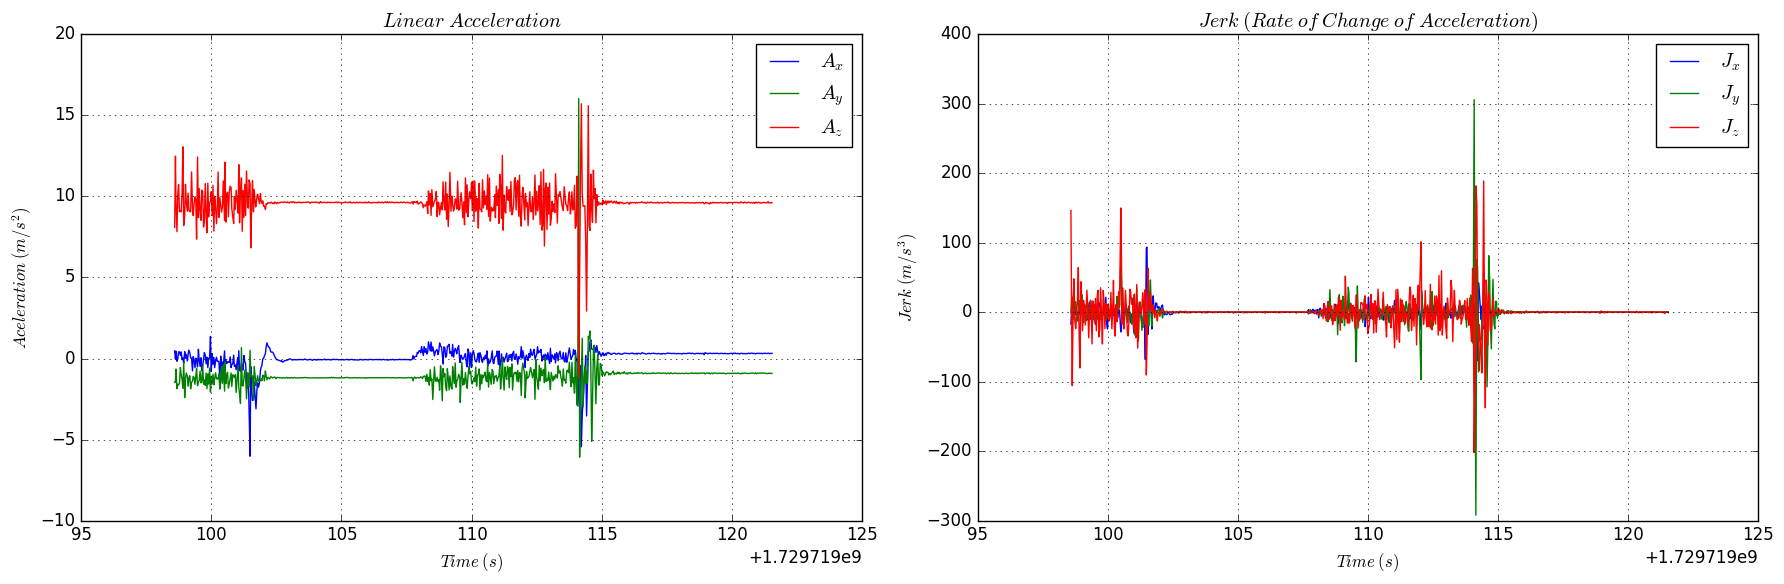

In [9]:
plt.figure(figsize=(18, 6))
plt.style.use('classic')

# Subplot of the accel
plt.subplot(1, 2, 1)
for axis in ['x', 'y', 'z']:
    plt.plot(data_jerk["time(s)"], data_jerk[f"linear_acceleration_{axis}"], label=f"Aceleración {axis}")
plt.title(r"$Linear\;Acceleration$")
plt.xlabel(r"$Time\; (s)$")
plt.ylabel(r"$Aceleration\; (m/s^2)$")
plt.legend([r"$A_{x}$", r"$A_{y}$", r"$A_{z}$"])
plt.grid()

# Subplot of jerk per ax
plt.subplot(1, 2, 2)
for axis in ['x', 'y', 'z']:
    plt.plot(data_jerk["time(s)"], data_jerk[f"jerk_{axis}"], label=f"Jerk {axis}")
plt.title(r"$Jerk\; (Rate\; of\; Change\; of\; Acceleration)$")
plt.xlabel(r"$Time\; (s)$")
plt.ylabel(r"$Jerk\; (m/s^3)$")
plt.legend([r"$J_{x}$", r"$J_{y}$", r"$J_{z}$"])
plt.grid()

plt.tight_layout()
plt.show()


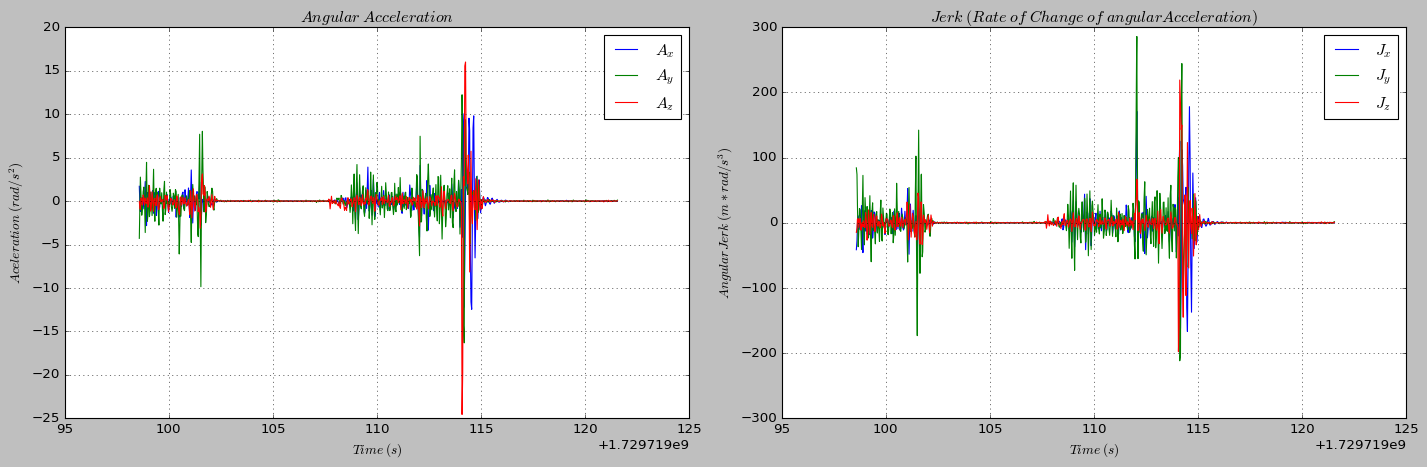

In [10]:
plt.figure(figsize=(18, 6))
plt.style.use('classic')
# Subplot de angular acc
plt.subplot(1, 2, 1)
for axis in ['x', 'y', 'z']:
    plt.plot(data_jerk["time(s)"], data_jerk[f"angular_acceleration_{axis}"], label=f"Aceleración _angular{axis}")
plt.title(r"$Angular\;Acceleration$")
plt.xlabel(r"$Time\; (s)$")
plt.ylabel(r"$Aceleration\; (rad/s^2)$")
plt.legend([r"$A_{x}$", r"$A_{y}$", r"$A_{z}$"])
plt.grid()

# Subplot of jerk per
plt.subplot(1, 2, 2)
for axis in ['x', 'y', 'z']:
    plt.plot(data_jerk["time(s)"], data_jerk[f'angular_jerk_{axis}'], label=f"Angular Jerk {axis}")
plt.title(r"$Jerk\; (Rate\; of\; Change\; of\; angular Acceleration)$")
plt.xlabel(r"$Time\; (s)$")
plt.ylabel(r"$Angular Jerk\; ( m * rad/s^3)$")
plt.legend([r"$J_{x}$", r"$J_{y}$", r"$J_{z}$"])
plt.grid()

plt.tight_layout()
plt.show()


- Now we can apply the filter to the jerk so, we can obtain the next column

In [11]:
# hyper parameter of convex filter 
eta = 0.1
for axis in ['x', 'y', 'z']:
    data_jerk[f'filter_jerk_{axis}'] = (1 - eta) * data_jerk[f"jerk_{axis}"] + eta * data_jerk[f'angular_jerk_{axis}']

- We can obtain the boxplots in order to get atypical data of collisions.

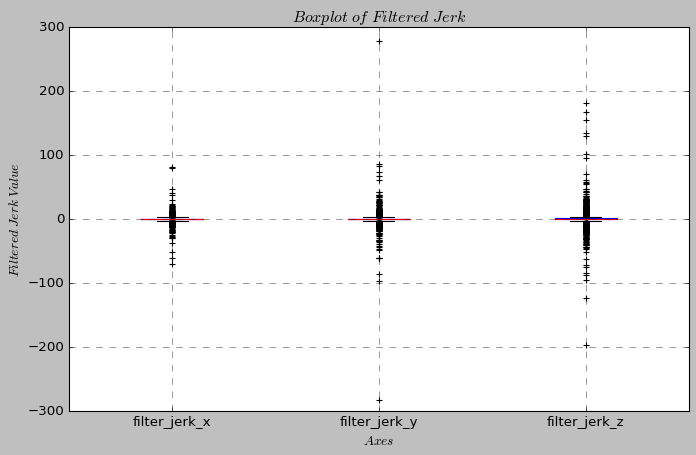

In [12]:
plt.figure(figsize=(10, 6))
data_jerk[['filter_jerk_x', 'filter_jerk_y', 'filter_jerk_z']].boxplot()
plt.title(r"$Boxplot\;of\ Filtered\ Jerk$")
plt.ylabel(r"$Filtered\;Jerk\;Value$")
plt.xlabel("$Axes$")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

- Get the max values of axes

In [13]:
# variables 
max_jerk = {'x':data_jerk['filter_jerk_x'].max() , 'y':data_jerk['filter_jerk_y'].max(), 'z':data_jerk['filter_jerk_z'].max()}
print(max_jerk.items())

dict_items([('x', 80.75866814219981), ('y', 277.56377087725525), ('z', 181.7905227111135)])


In [14]:
data_jerk[f'filter_jerk_vector'] = np.sqrt((data_jerk[f'filter_jerk_x'])**2  + (data_jerk[f'filter_jerk_y'])**2  + (data_jerk[f'filter_jerk_z'])**2)

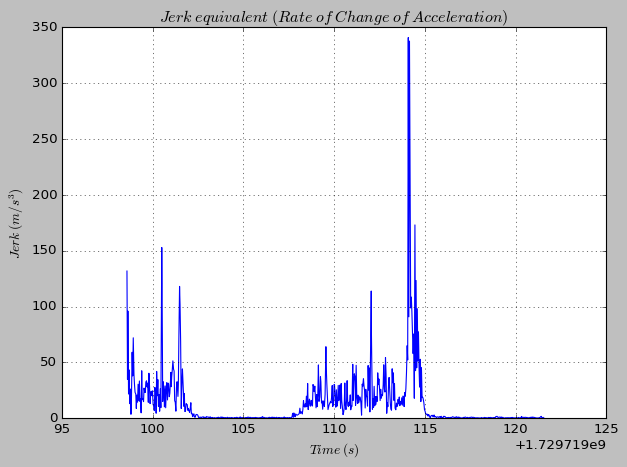

In [15]:
plt.plot(data_jerk["time(s)"], data_jerk[f'filter_jerk_vector'])
plt.title(r"$Jerk\;equivalent\; (Rate\; of\; Change\; of\; Acceleration)$")
plt.xlabel(r"$Time\; (s)$")
plt.ylabel(r"$Jerk\; (m/s^3)$")
plt.grid()

plt.tight_layout()
plt.show()

- Plot of the axes from the filtered jerk

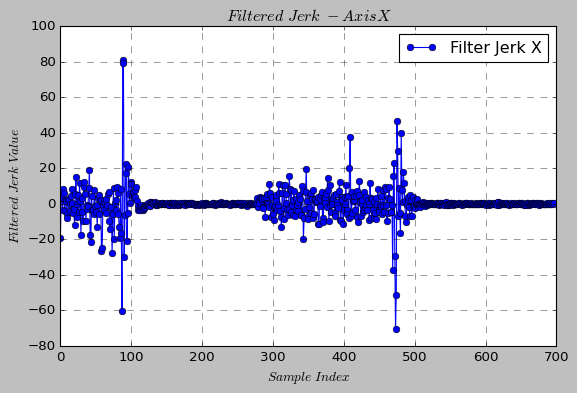

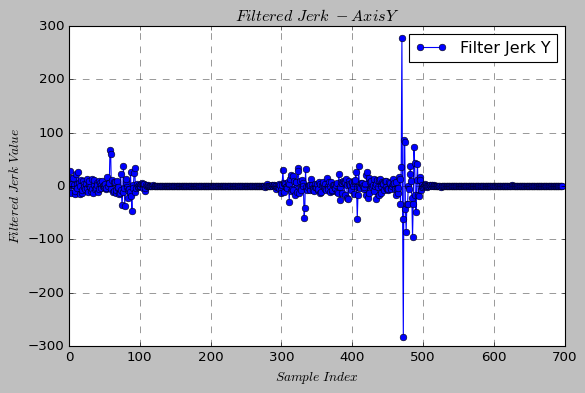

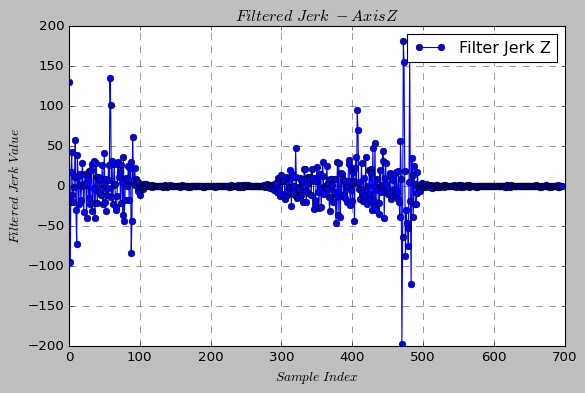

In [16]:
# Each filtered jerk component 
for axis in ['x', 'y', 'z']:
    plt.figure(figsize=(8, 5))
    plt.plot(data_jerk[f'filter_jerk_{axis}'], label=f'Filter Jerk {axis.upper()}', marker='o')
    plt.title(f"$Filtered\ Jerk\ - Axis {axis.upper()}$")
    plt.ylabel("$Filtered\ Jerk\ Value$")
    plt.xlabel("$Sample\ Index$")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


- Other files analisys

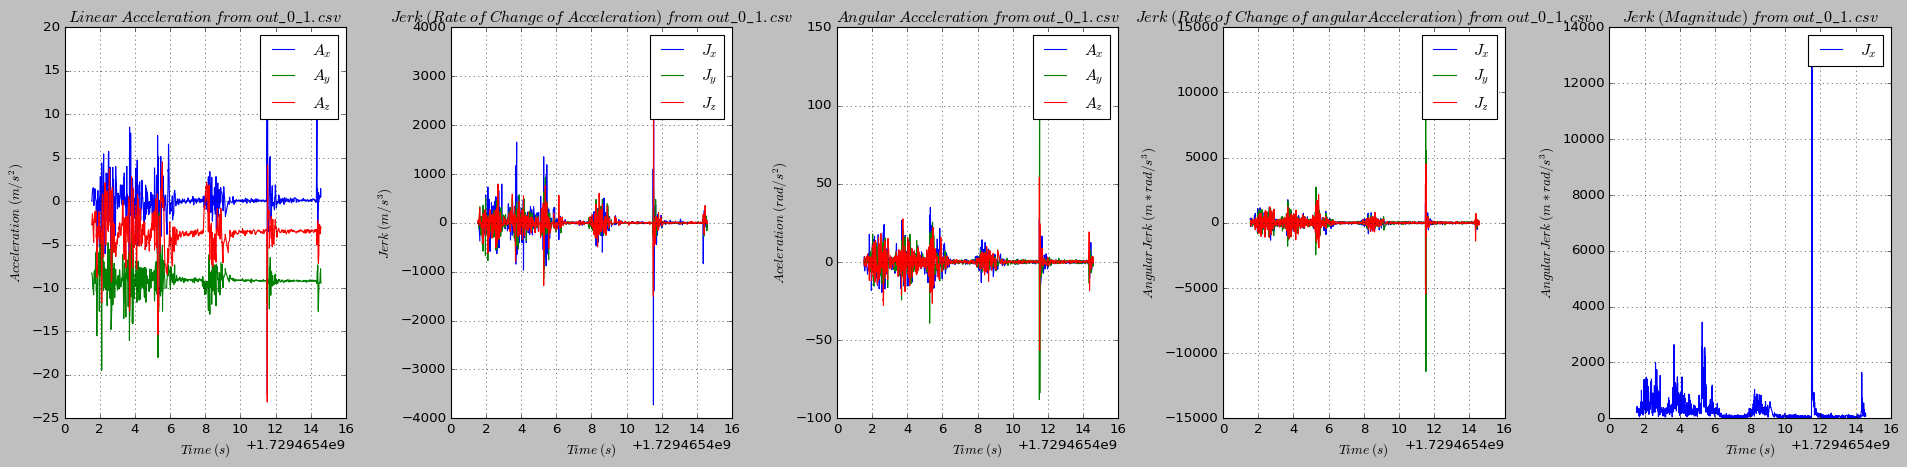

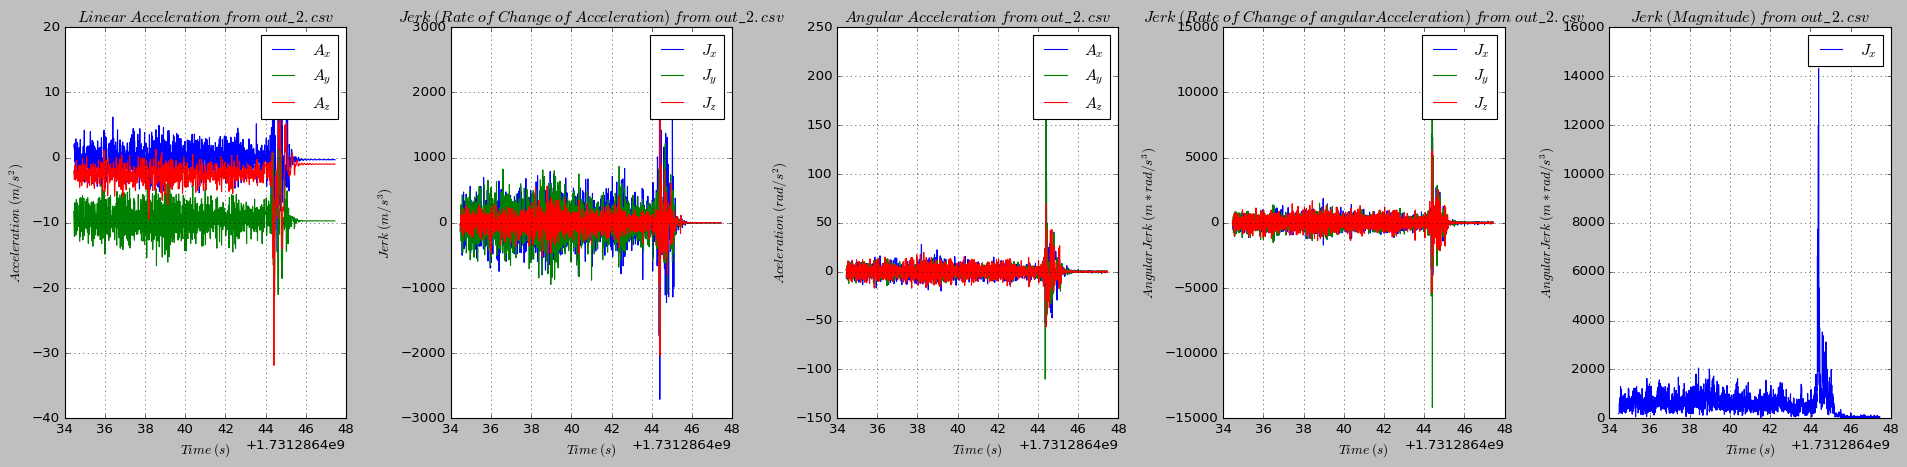

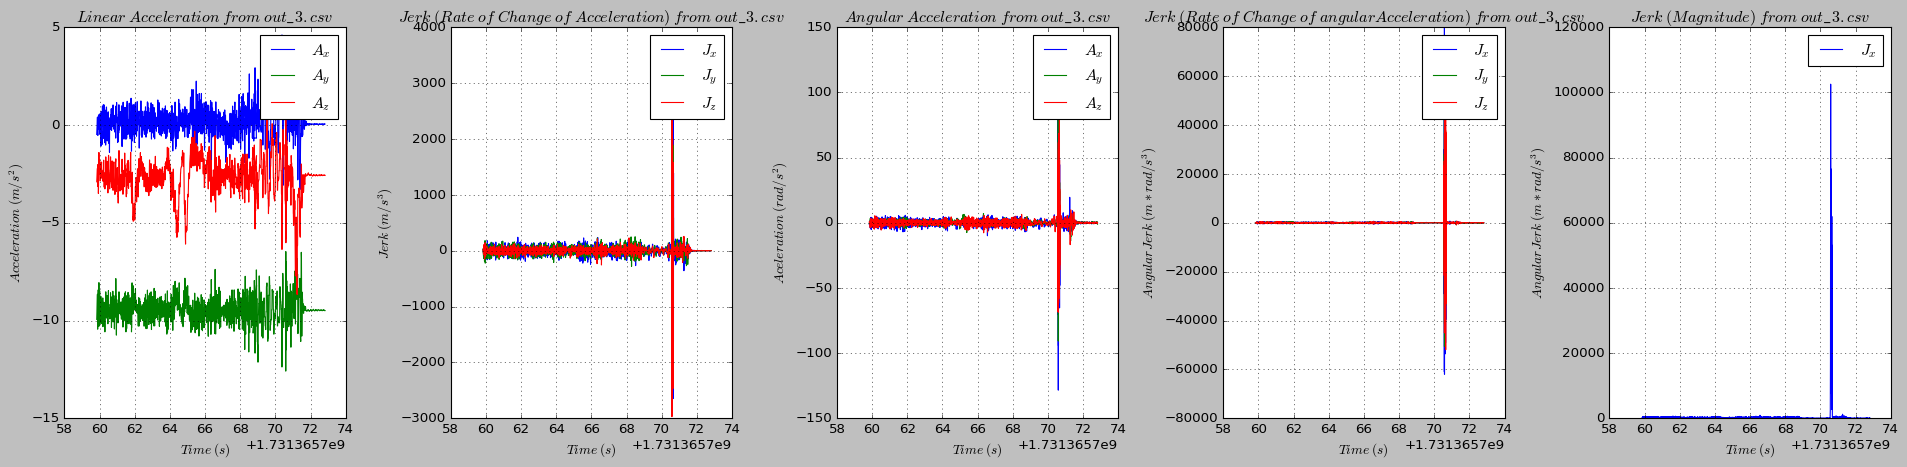

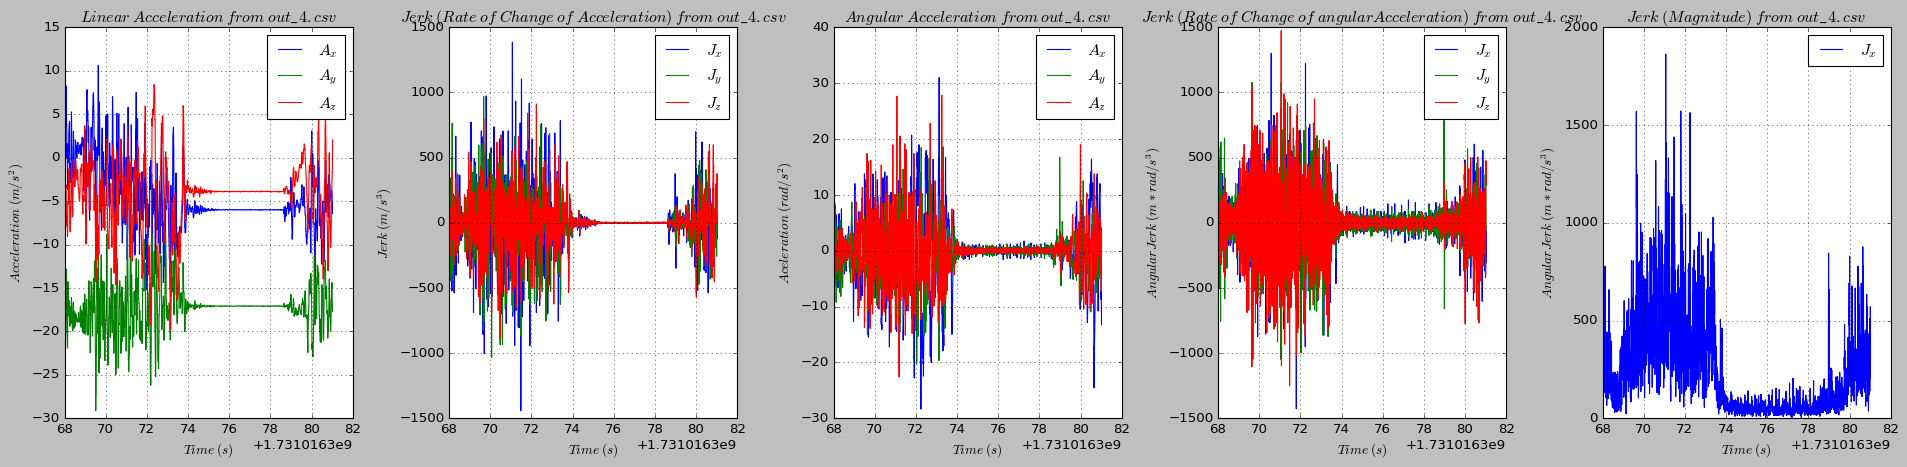

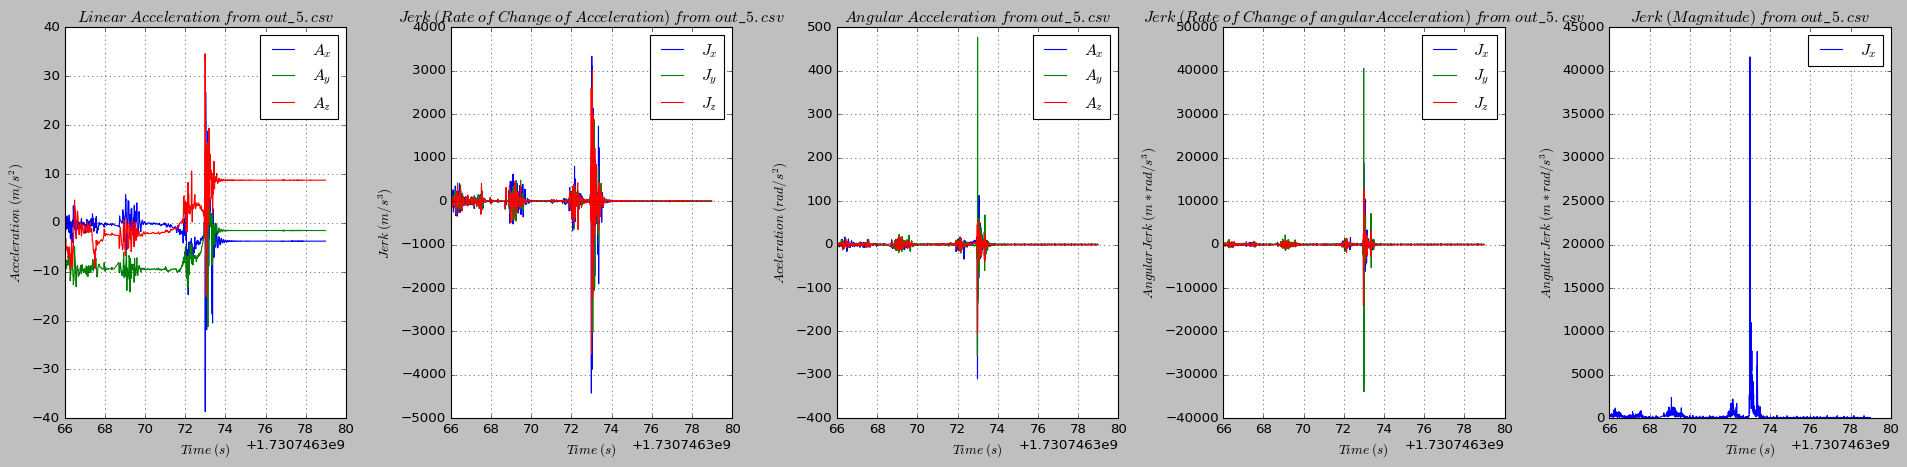

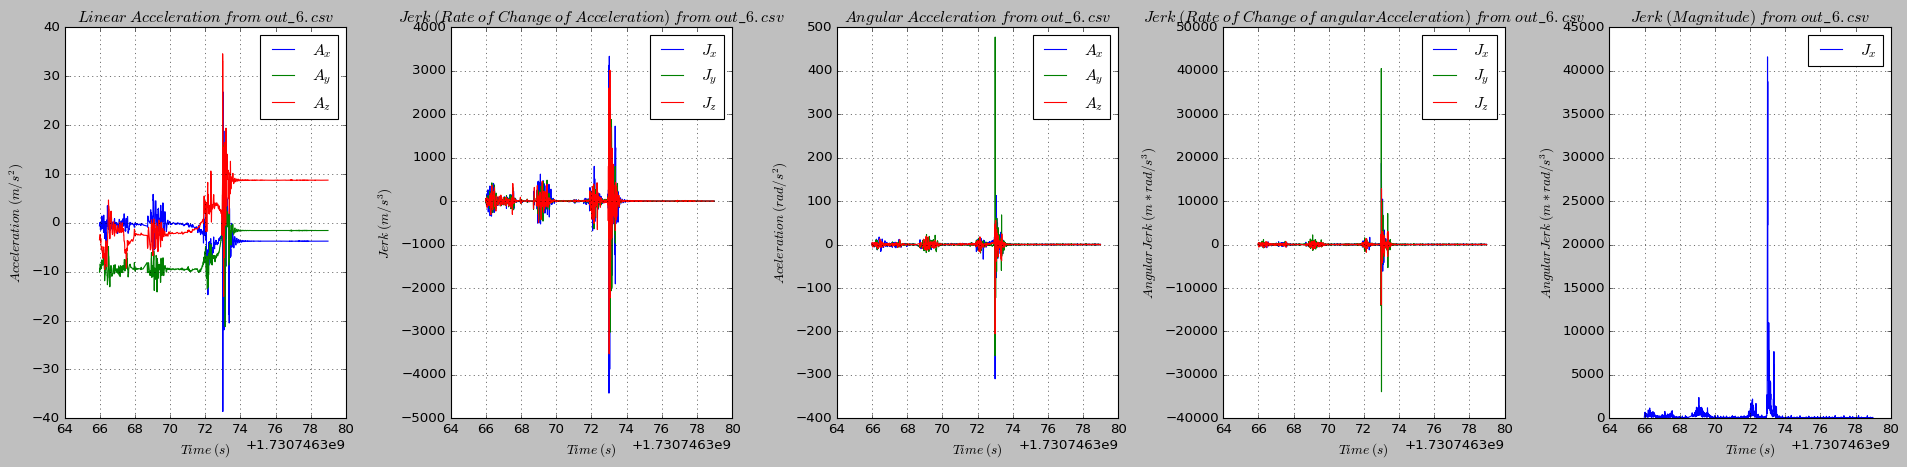

In [17]:
for instance in data_instances:
    instance.process_data(0.559)
    instance.plot_data()

## Test firts approach
--- 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Gen a threshold
jerk_threshold = 100
data_jerk['collision_risk'] = ((data_jerk['jerk_x'] > jerk_threshold) | 
                        (data_jerk['jerk_y'] > jerk_threshold) | 
                        (data_jerk['jerk_z'] > jerk_threshold)).astype(int)

# Get the features and labels
features = ['linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
            'jerk_x', 'jerk_y', 'jerk_z']
X = data_jerk[features]
y = data_jerk['collision_risk']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Eval
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       209
           1       1.00      1.00      1.00         1

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



In [19]:
# support from https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn
import joblib
joblib.dump(model, 'collision_detection_model.pkl')

['collision_detection_model.pkl']

- windows

In [20]:
%pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


- Linux

In [21]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [22]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import StandardScaler

# # Scale data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Convert to tensor
# X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
# y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# # Split Data 
# train_size = int(0.7 * len(X_tensor))
# X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
# y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

# # nn
# class CollisionModel(nn.Module):
#     def __init__(self):
#         super(CollisionModel, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(X_tensor.shape[1], 16),
#             nn.ReLU(),
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         return self.fc(x)

# model = CollisionModel()
# criterion = nn.BCELoss()  # to binary classification
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# epochs = 1000
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     y_pred = model(X_train)
#     loss = criterion(y_pred, y_train)
#     loss.backward()
#     optimizer.step()
    
#     # Validate the model
#     if (epoch + 1) % 10 == 0:
#         model.eval()
#         with torch.no_grad():
#             val_pred = model(X_val)
#             val_loss = criterion(val_pred, y_val)
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


## Definitive Solution Mision 1
---

In [23]:
# import tensorflow as tf

- My first step is to define the model inputs in order to capture 3 scenarios in which it will be possible to solve the first mission. For this, we will use the first 4 files, taking into account that they are the ones that present this type of behavior based on the jerk type. At the end, I will make a truth table associated with the roll over so that it does not generate noise when obtaining the data.

/home/krita/Downloads/rkt/data_handler.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time(s)'] = self.data['time(s)'].iloc[start_index:end_index + 1]
/home/krita/Downloads/rkt/data_handler.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["normalized_time"] = new_df[time_column] - time_offset


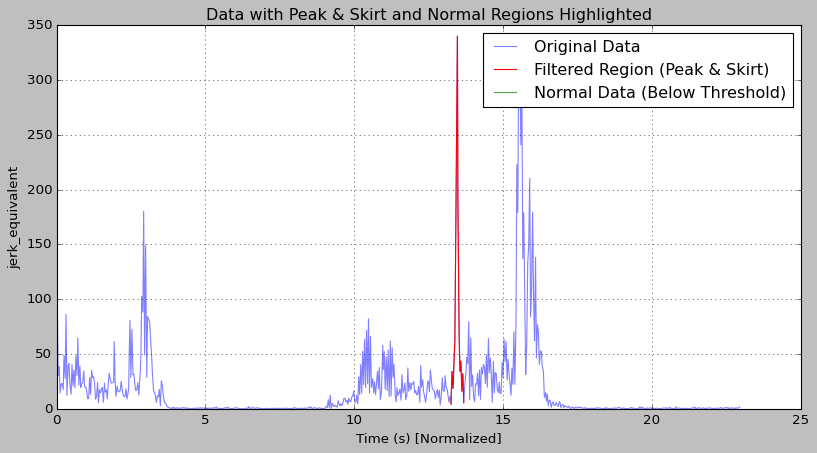

In [24]:
COLUMN_OF_INTEREST = f'jerk_equivalent'
skirt = 0.02

diagnostic = Data('out0_cam.csv')
diagnostic.process_data(0.559)

# This case the collision is on the second peak 

[data_diagnostic_collision_before, 
max_value_diagnostic_before, 
data__diagnostic_left_before, 
data__diagnostic_rigth_before, 
max_index_diag_before, 
start_diag, end_diag_before] = diagnostic.get_peak_and_skirt(COLUMN_OF_INTEREST, skirt)

diagnostic.plot_data_with_regions(COLUMN_OF_INTEREST, "time(s)", data_diagnostic_collision_before, skirt)

<AxesSubplot: >

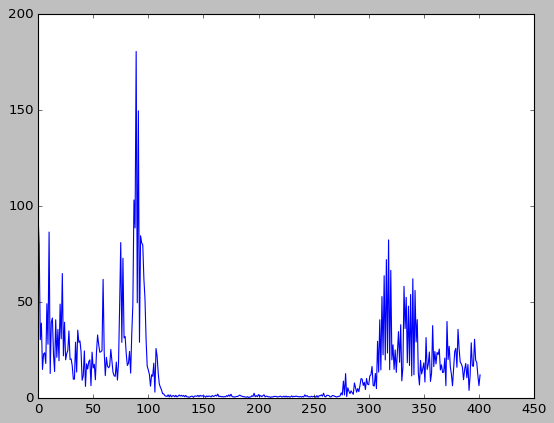

In [25]:
data__diagnostic_left_before[COLUMN_OF_INTEREST].plot()

/home/krita/Downloads/rkt/data_handler.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["normalized_time"] = new_df[time_column] - time_offset


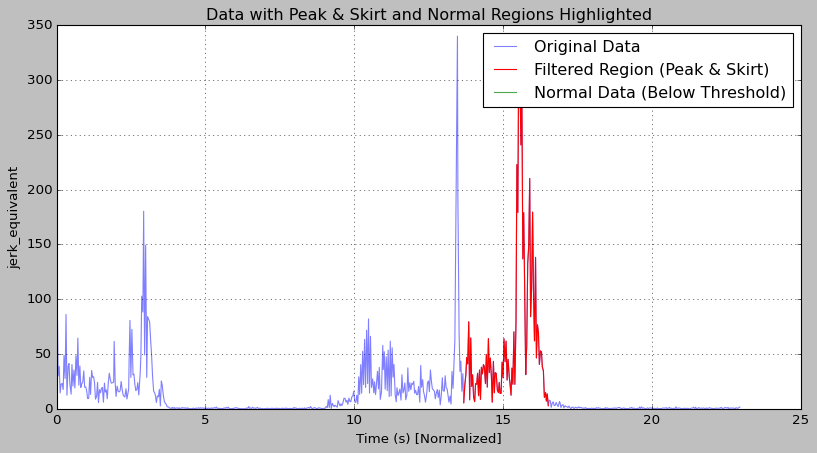

Collision time: 15.528687715530396
Collision min time: 13.680077314376831
Collision max time: 16.520936965942383
Time event: 2.8408596515655518


In [26]:
COLUMN_OF_INTEREST = f'jerk_equivalent'
skirt = 0.018
# skirt = 0.07
diagnostic = Data('out0_cam.csv')
diagnostic.process_data(0.559)

# This case the collision is on the second peak 

[data_diagnostic_collision, 
max_value_diagnostic, 
data__diagnostic_left, 
data__diagnostic_rigth, 
max_index_diag, 
start_diag, end_diag] = diagnostic.get_second_peak_and_skirt(COLUMN_OF_INTEREST, skirt)

diagnostic.plot_data_with_regions(COLUMN_OF_INTEREST, "time(s)", data_diagnostic_collision, skirt)
print(f"Collision time: {(diagnostic.data['time(s)'][max_index_diag] - diagnostic.data['time(s)'][0])}")
print(f"Collision min time: {(diagnostic.data['time(s)'][start_diag] - diagnostic.data['time(s)'][0])}")
print(f"Collision max time: {(diagnostic.data['time(s)'][end_diag] - diagnostic.data['time(s)'][0])}")
print(f"Time event: {diagnostic.data['time(s)'][end_diag] - diagnostic.data['time(s)'][start_diag]}")


In [27]:
data_diagnostic_collision['jerk_equivalent'].max() / (diagnostic.data['time(s)'][end_diag] - diagnostic.data['time(s)'][start_diag])

115.98470104686275

## Collision 1: 40.82732527210398

In [28]:
data_diagnostic_collision.shape[0]

87

In [29]:
data_diagnostic_collision[COLUMN_OF_INTEREST]

415     5.624701
416    21.177160
417    32.049137
418    46.984864
419    41.117655
         ...    
497    10.613700
498    14.992674
499     7.161259
500    13.728510
501     2.956181
Name: jerk_equivalent, Length: 87, dtype: float64

/home/krita/Downloads/rkt/data_handler.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time(s)'] = self.data['time(s)'].iloc[start_index:end_index + 1]
/home/krita/Downloads/rkt/data_handler.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["normalized_time"] = new_df[time_column] - time_offset


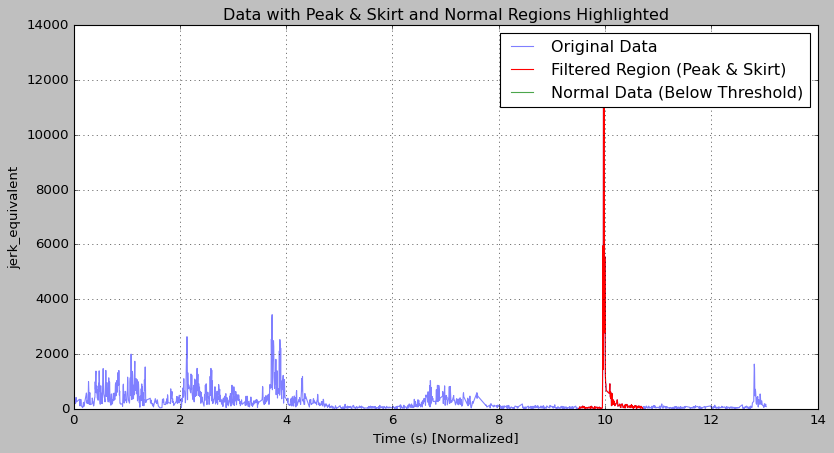

Collision time: 9.970696926116943
Collision min time: 9.500003337860107
Collision max time: 10.711686849594116
Time event: 1.2116835117340088


In [30]:
skirt0 = 0.0006128755


[data_0_bump, 
max_value_0, 
data_0_left, 
data_0_rigth, 
max_index_0, 
start_0, end_0] = data_instances[0].get_peak_and_skirt(COLUMN_OF_INTEREST, skirt0)

data_instances[0].plot_data_with_regions(COLUMN_OF_INTEREST, "time(s)", data_0_bump, skirt0)
print(f"Collision time: {(data_instances[0].data['time(s)'][max_index_0] - data_instances[0].data['time(s)'][0])}")
print(f"Collision min time: {(data_instances[0].data['time(s)'][start_0] - data_instances[0].data['time(s)'][0])}")
print(f"Collision max time: {(data_instances[0].data['time(s)'][end_0] - data_instances[0].data['time(s)'][0])}")
print(f"Time event: {data_instances[0].data['time(s)'][end_0] - data_instances[0].data['time(s)'][start_0]}")

## Bump: 45435.67280689195

<AxesSubplot: >

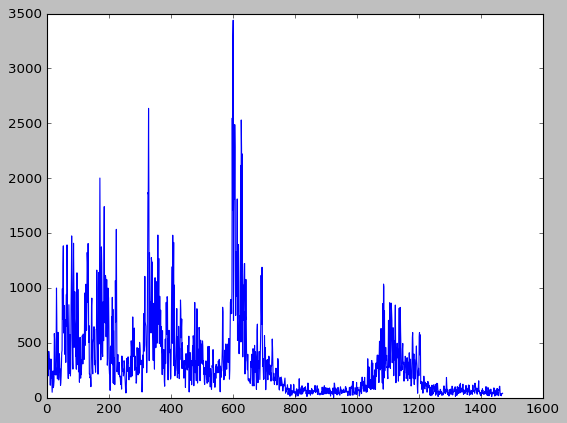

In [31]:
data_0_left[COLUMN_OF_INTEREST].plot()

/home/krita/Downloads/rkt/data_handler.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time(s)'] = self.data['time(s)'].iloc[start_index:end_index + 1]
/home/krita/Downloads/rkt/data_handler.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["normalized_time"] = new_df[time_column] - time_offset
/home/krita/Downloads/rkt/data_handler.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

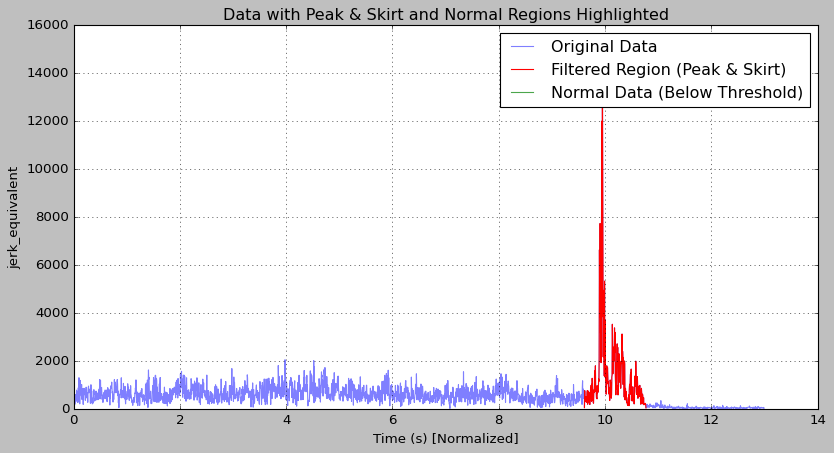

Collision time: 9.920060396194458
Collision min time: 9.582191467285156
Collision max time: 10.740499019622803
Time event: 1.1583075523376465


In [32]:
skirt1 = 0.003888

[data_1_collision, 
max_value_1, 
data_1_left, 
data_1_rigth, 
max_index_1, 
start_1, end_1] = data_instances[1].get_peak_and_skirt(COLUMN_OF_INTEREST, skirt1)

data_instances[1].plot_data_with_regions(COLUMN_OF_INTEREST, "time(s)", data_1_collision, skirt1)
print(f"Collision time: {(data_instances[1].data['time(s)'][max_index_1] - data_instances[1].data['time(s)'][1])}")
print(f"Collision min time: {(data_instances[1].data['time(s)'][start_1] - data_instances[1].data['time(s)'][1])}")
print(f"Collision max time: {(data_instances[1].data['time(s)'][end_1] - data_instances[1].data['time(s)'][1])}")
print(f"Time event: {data_instances[1].data['time(s)'][end_1] - data_instances[1].data['time(s)'][start_1]}")


In [33]:
data_instances[1].data['jerk_equivalent'].max() / (data_instances[1].data['time(s)'][end_1] - data_instances[1].data['time(s)'][start_1])

12363.404978609511

## Collision 2: 12363.404978609511

<AxesSubplot: >

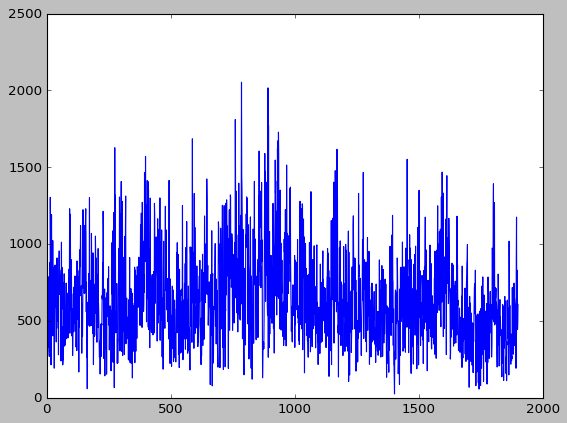

In [34]:
data_1_left[COLUMN_OF_INTEREST].plot() # normal

/home/krita/Downloads/rkt/data_handler.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['time(s)'] = self.data['time(s)'].iloc[start_index:end_index + 1]
/home/krita/Downloads/rkt/data_handler.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["normalized_time"] = new_df[time_column] - time_offset


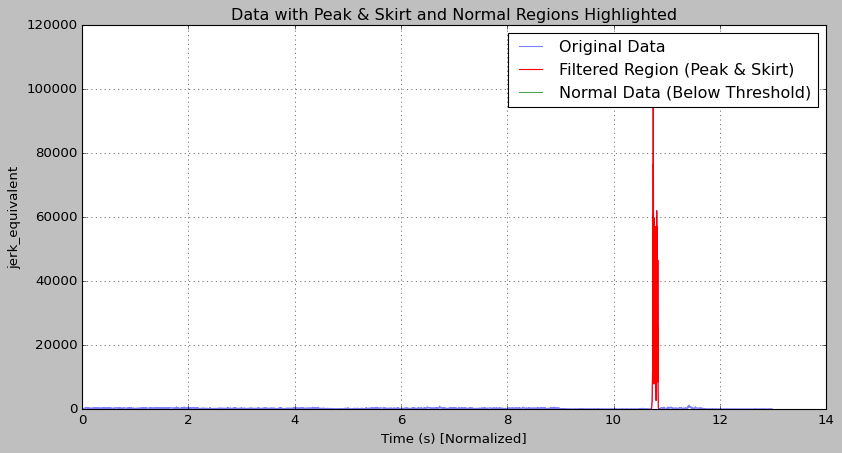

Collision time: 10.69698691368103
Collision min time: 10.664443254470825
Collision max time: 10.803290367126465
Time event: 0.13884711265563965


In [35]:
# note: impute data with 0

skirt2 = 0.002

[data_2_bump, 
max_value_2, 
data_2_left, 
data_2_rigth, 
max_index_2, 
start_2, end_2] = data_instances[2].get_peak_and_skirt(COLUMN_OF_INTEREST, skirt2)

data_instances[2].plot_data_with_regions(COLUMN_OF_INTEREST, "time(s)", data_2_bump, skirt2)
print(f"Collision time: {(data_instances[2].data['time(s)'][max_index_2] - data_instances[2].data['time(s)'][2])}")
print(f"Collision min time: {(data_instances[2].data['time(s)'][start_2] - data_instances[2].data['time(s)'][2])}")
print(f"Collision max time: {(data_instances[2].data['time(s)'][end_2] - data_instances[2].data['time(s)'][2])}")
print(f"Time event: {data_instances[2].data['time(s)'][end_2] - data_instances[2].data['time(s)'][start_2]}")

In [36]:
data_instances[2].data['jerk_equivalent'].max() / (data_instances[2].data['time(s)'][end_2] - data_instances[2].data['time(s)'][start_2])

738623.6630885052

## Bump 2: 738623.6630885052

> Death step: I notice that is important to take just the left side before the event.

<AxesSubplot: >

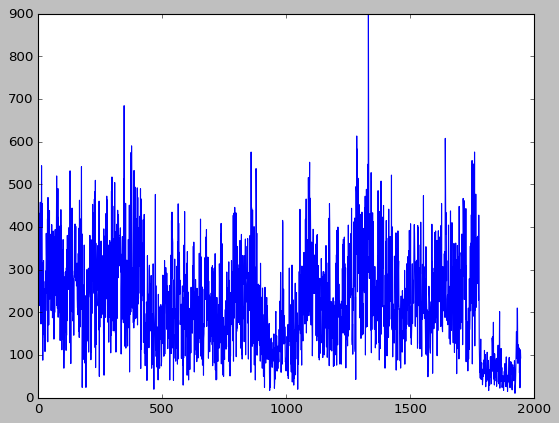

In [37]:
data_2_left[COLUMN_OF_INTEREST].plot() # normal/terrain 

In [38]:
dataframes_esp = [
    data_diagnostic_collision, 
    data_0_bump,  
    data_1_collision, 
    data_2_bump, 
]
dataframes_normal = [
    data__diagnostic_left_before,
    data_0_left,
    data_1_left,
    data_2_left
]
labels_esp = [
    "collision",
    "bump", 
    "collision",
    "bump",
]
labels_normal = ["normal"] * len(dataframes_normal)
for i in range(len(dataframes_esp )):
    print(dataframes_esp [i].shape[0])

87
214
229
205


In [39]:
from utils import (
    resample_preserving_temporal_profile,
    random_cut_and_interpolate,
    convert_model
)


2024-11-24 01:11:04.978924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732428665.615227 2531529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732428665.673191 2531529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 01:11:06.560975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
important_columns = ['jerk_equivalent', 'time(s)']

def adjust(df):
    global important_columns
    df = df[important_columns]
    df = df.copy()
    time_offset = df['time(s)'].iloc[0]
    df['time(s)_n'] = df['time(s)'] - time_offset
    return df

data_diagnostic_collision = adjust(data_diagnostic_collision)
data_0_bump = adjust(data_0_bump)
data_1_collision = adjust(data_1_collision)
data_2_bump = adjust(data_2_bump)

data__diagnostic_left_before= adjust(data__diagnostic_left_before)
data_0_left = adjust(data_0_left)
data_1_left = adjust(data_1_left)
data_2_left = adjust(data_2_left)

In [41]:
target_length = 1000

In [42]:
data_diagnostic_collision['time(s)_n'].iloc[-1]

2.8408596515655518

- Resampling to obtain more point on the selected size 

In [43]:
time_total1 = data_diagnostic_collision['time(s)_n'].iloc[-1]
data_diagnostic_collision['jerk_equivalent'] = data_diagnostic_collision['jerk_equivalent'] / time_total1
d1 = resample_preserving_temporal_profile(data_diagnostic_collision, target_length )

In [44]:
time_total2 = data_0_bump['time(s)_n'].iloc[-1]
data_0_bump['jerk_equivalent'] = data_0_bump['jerk_equivalent'] / time_total2
d2 = resample_preserving_temporal_profile(data_0_bump, target_length)

In [45]:
time_total3 = data_1_collision['time(s)_n'].iloc[-1]
data_1_collision['jerk_equivalent'] = data_1_collision['jerk_equivalent'] / time_total3
d3 = resample_preserving_temporal_profile(data_1_collision, target_length)

In [46]:
time_total4 = data_2_bump['time(s)_n'].iloc[-1]
data_2_bump['jerk_equivalent'] = data_2_bump['jerk_equivalent'] / time_total4
d4 = resample_preserving_temporal_profile(data_2_bump, target_length)

- Resampling effects

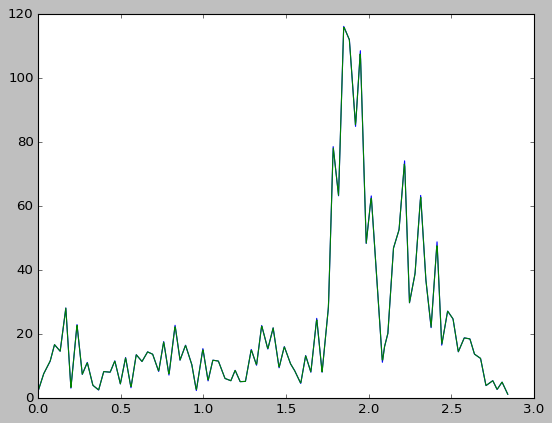

In [47]:
plt.plot(data_diagnostic_collision['time(s)_n'], data_diagnostic_collision['jerk_equivalent'])
plt.plot(d1['time(s)'], d1['jerk_equivalent'])
plt.show()

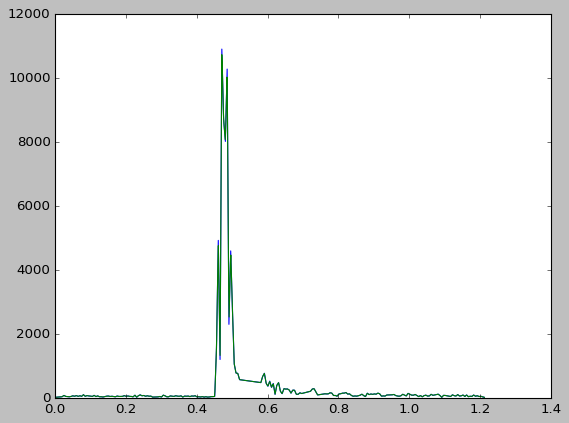

In [48]:
plt.plot(data_0_bump['time(s)_n'], data_0_bump['jerk_equivalent'])
plt.plot(d2['time(s)'], d2['jerk_equivalent'])
plt.show()

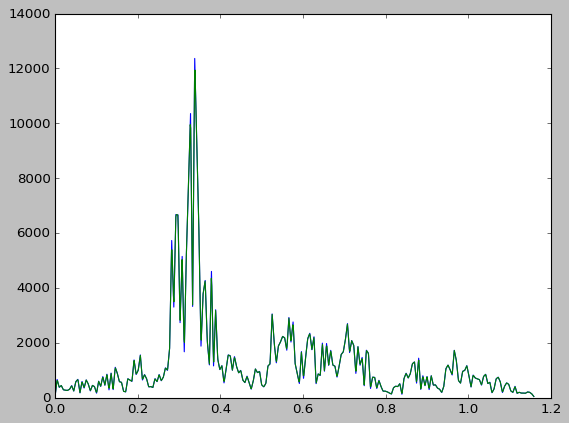

In [49]:
plt.plot(data_1_collision['time(s)_n'], data_1_collision['jerk_equivalent'])
plt.plot(d3['time(s)'], d3['jerk_equivalent'])
plt.show()

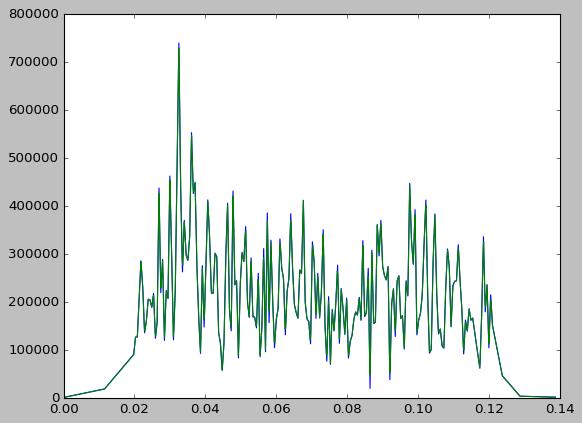

In [50]:
plt.plot(data_2_bump['time(s)_n'], data_2_bump['jerk_equivalent'])
plt.plot(d4['time(s)'], d4['jerk_equivalent'])
plt.show()

- Random cut and interpolate for the normal behavior data

In [51]:
n1 = random_cut_and_interpolate(data__diagnostic_left_before, target_length, 2.8408596515655518)
n2 = random_cut_and_interpolate(data_0_left, target_length, 2.8408596515655518)
n3 = random_cut_and_interpolate(data_1_left, target_length, 2.8408596515655518)
n4 = random_cut_and_interpolate(data_2_left, target_length, 2.8408596515655518)

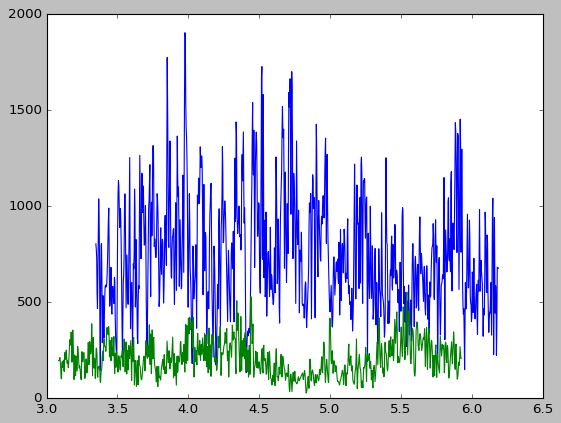

In [52]:
plt.plot(n3['time(s)'], n3['jerk_equivalent'])
plt.plot(n4['time(s)'], n4['jerk_equivalent'])
plt.show()

> NN Creation

- Creation of the training vector

In [53]:
dataframes = [d1, d2, d3, d4, n3, n4] # delete 2 for balancing the model 
# it could affect the model a lot ._.
labels_normal_del = ["normal"] * 2
labels = labels_esp + labels_normal_del
print(labels)
X = np.array([df['jerk_equivalent'].values for df in dataframes])
print(f"Forma de X: {X.shape}")

['collision', 'bump', 'collision', 'bump', 'normal', 'normal']
Forma de X: (6, 1000)


- Reshape in order to get vector to entry on a categorical mode

In [54]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Forma ajustada de X: {X.shape}")

Forma ajustada de X: (6, 1000, 1)


- One Hot Encoder in order to get dummies from categorical variables.

In [55]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(np.array(labels).reshape(-1, 1))
print(f"Forma de y: {y.shape}")
print("One-hot encoding de etiquetas:")
print(y)

Forma de y: (6, 3)
One-hot encoding de etiquetas:
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


- Split the data over:

> Test 15%

> Validation 15%  

> Train 70% 

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Training: (4, 1000, 1), (4, 3)
Validation: (1, 1000, 1), (1, 3)
Test: (1, 1000, 1), (1, 3)


In [57]:
from nn import LSTMModel

input_shape = (X_train.shape[1], X_train.shape[2])  # Dimensiones de entrada (timesteps, features)
num_classes = y_train.shape[1]  # Número de clases

lstm_model = LSTMModel(input_shape, num_classes)
lstm_model.build_model()
lstm_model.compile_model()

Model built successfully.


2024-11-24 01:11:13.445734: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/krita/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,963 (347.51 KB)

 Trainable params: 88,643 (346.26 KB)

 Non-trainable params: 320 (1.25 KB)

Model compiled successfully.


In [59]:
history = lstm_model.train_model(X_train, y_train, X_val, y_val)

Starting training...
Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - accuracy: 0.2500 - loss: 1.3087 - val_accuracy: 1.0000 - val_loss: 1.0127 - learning_rate: 1.0000e-06
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - accuracy: 0.2500 - loss: 1.2112 - val_accuracy: 1.0000 - val_loss: 1.0105 - learning_rate: 1.0000e-06
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.0000e+00 - loss: 2.1999 - val_accuracy: 1.0000 - val_loss: 1.0078 - learning_rate: 1.0000e-06
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step - accuracy: 0.2500 - loss: 1.3195 - val_accuracy: 1.0000 - val_loss: 1.0045 - learning_rate: 1.0000e-06
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - accuracy: 0.2500 - loss: 1.5705 - val_accuracy: 1.0000 - val_loss: 1.0015 - learning_rate: 1.0000e-06
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 0.2500 - loss: 1.2601 - val_accuracy: 1.0000 - val_loss: 0.9993 - learning_rate: 1.0000e-06
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

KeyboardInterrupt: 

In [59]:
test_loss, test_accuracy = lstm_model.evaluate_model(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0000e+00 - loss: 2.6567
Test Loss: 2.6567, Test Accuracy: 0.0000


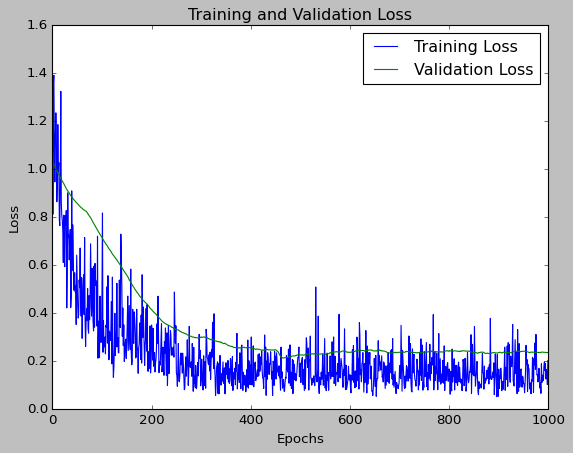

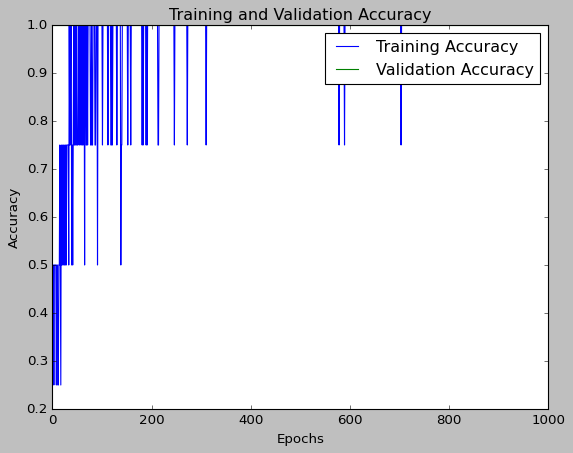

In [60]:
lstm_model.plot_training_history(history)

In [77]:
new_data = np.random.random((1, X_train.shape[1], X_train.shape[2]))  # Dato aleatorio
predicted_label = lstm_model.predict_new_data(new_data, encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: [['collision']]


In [87]:
# d -> specials
# n -> normal

real_labels = ['collision', 'bump', 'normal']  # Lista de etiquetas reales
sample_index = 2  # Índice de la muestra a validar
lstm_model.validate_sample(n2, real_labels, encoder, sample_index)

# Failure on 1 Normal bug fix it

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Actual Label: normal
Predicted Label: ['normal']
Correct Prediction 🎉


In [88]:
# Save the model
# lstm_model.save_model("model_conditions_2.h5")

Model saved to model_conditions_2.h5.


In [61]:
convert_model("model_conditions.h5", "model_conditions_original.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpqrr86ecx/assets


INFO:tensorflow:Assets written to: /tmp/tmpqrr86ecx/assets


Saved artifact at '/tmp/tmpqrr86ecx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1000, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  125351989988688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989767760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989994496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989824144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989825904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989822912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989824672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989835408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989833648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351989837168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125351990123280: 

W0000 00:00:1732428858.715383 2531529 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732428858.715398 2531529 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-24 01:14:18.715573: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpqrr86ecx
2024-11-24 01:14:18.716725: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-24 01:14:18.716741: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpqrr86ecx
2024-11-24 01:14:18.731281: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-24 01:14:18.800847: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpqrr86ecx
2024-11-24 01:14:18.829331: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 113763 microseconds.
2024-11-24 01:14:18.960319: W tensorflow/com

## Second Model (conservative way)
---
Once the model was obtained, a signal assurance protocol was created, where a second model was generated in which the maximum peaks between the sampling times were related, relating changes between jerk with a percentage close to $x_{i}$ for each type of movement. So I can obtain the next model:
- Suppose that we have $P_{k}$ were it represents the maximum value of frame/queue of data, so on a define time we have:
$$\frac{P_{1}}{t_{sample}} <\frac{P_{2}}{t_{sample}}<\frac{P_{3}}{t_{sample}}$$
- But indeed this $t_{sample}$ does not represent the differents between the categories, so to correct it I am going to calculate the time of "landing" for each event I can aproximate the difference between the actual and the past data from the jerk emulating the Snap that is the derivate of the jerk, with this way I can obtain:
$$\frac{P_{1}}{t_{1}} <\frac{P_{2}}{t_{2}}<\frac{P_{3}}{t_{3}}$$
That represent with more fidelity the event.

To do that I consider two options in order to be efficient:
### 1. Aproximate the derivate with pairs, estimating where the signal launch and land.
### 2. Look for the peak and get a skirt with the previus analisys and get the time.
Finally I consider that if both of them fullfill with my expectations the selected one would be the fastest.

In [64]:
diagnostic.data

,timestamp_sec,timestamp_nsec,orientation_x,orientation_y,orientation_z,orientation_w,angular_velocity_x,angular_velocity_y,angular_velocity_z,linear_acceleration_x,...,angular_acceleration_x,angular_jerk_x,jerk_y,angular_acceleration_y,angular_jerk_y,jerk_z,angular_acceleration_z,angular_jerk_z,jerk_equivalent,normalized_time
0,1729719098,589181820,-0.018265,-0.059284,0.095920,0.993454,-0.030000,0.028889,0.090000,0.47,...,1.701906,-41.357562,-0.665963,-4.291764,84.306650,146.178963,-0.036998,-14.723151,95.051724,0.000000
1,1729719098,619213648,-0.018004,-0.060938,0.097497,0.993205,0.021111,-0.100000,0.088889,-0.04,...,-0.519985,-27.562669,22.796959,0.237521,74.264531,-21.817906,-0.827984,-8.032239,79.620589,0.030032
2,1729719098,640154677,-0.017882,-0.061499,0.098564,0.993068,-0.022222,-0.028889,0.060000,0.45,...,-1.192177,-3.432957,12.768751,2.757268,29.479913,-105.676741,-0.954105,5.221290,30.134902,0.050973
3,1729719098,676619542,-0.018390,-0.061563,0.099072,0.993004,-0.010000,0.031111,0.052222,-0.17,...,0.232142,10.641968,-10.051966,0.388616,-36.738575,18.361550,0.362003,6.491389,38.795779,0.087438
4,1729719098,706997080,-0.018323,-0.061583,0.100155,0.992895,-0.005556,0.011111,0.077778,-0.03,...,0.303758,1.724642,4.054991,-1.627220,-12.696129,47.936392,0.095262,-7.082457,14.639921,0.117815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,1729719121,418284202,0.014227,0.018649,0.337973,-0.940863,0.000000,0.001111,0.000000,0.33,...,-0.015798,0.208902,0.226127,0.053486,-1.054043,-1.786731,0.003236,0.592394,1.227020,22.829102
693,1729719121,448342335,0.014227,0.018649,0.337973,-0.940863,-0.001111,-0.001111,0.002222,0.29,...,0.000105,0.339311,-0.165167,-0.018352,-0.670237,-0.167051,0.036913,-0.276776,0.800596,22.859160
694,1729719121,478315537,0.014227,0.018649,0.337973,-0.940863,0.000000,0.000000,0.002222,0.32,...,0.020627,0.076960,0.185647,-0.018693,0.268846,0.050276,-0.026214,-0.518950,0.589500,22.889134
695,1729719121,515917373,0.014227,0.018649,0.337973,-0.940863,0.000000,-0.003333,0.000000,0.31,...,0.000000,-0.135982,-0.185775,0.022615,1.192912,-0.135689,-0.005565,0.579064,1.332983,22.926735


In [65]:
diagnostic.data['snap'] = np.gradient(diagnostic.data['jerk_equivalent'], diagnostic.data['normalized_time'])
for i in range(len(data_instances)):
    value = data_instances[i].data['time(s)'].loc[0]
    data_instances[i].data['normalized_time'] = data_instances[i].data['time(s)'] - value
    data_instances[i].data['snap'] = np.gradient(data_instances[i].data['jerk_equivalent'], data_instances[i].data['normalized_time'])

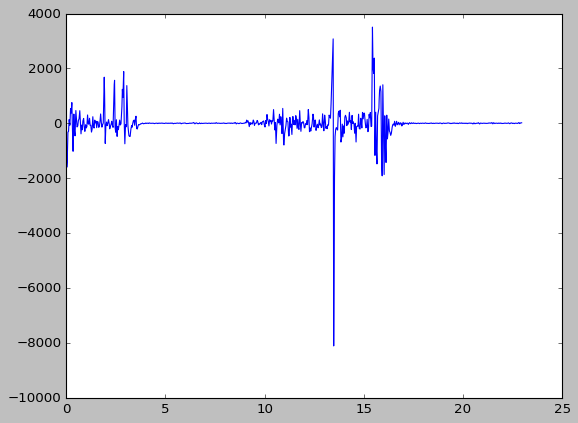

In [66]:
plt.plot(diagnostic.data['normalized_time'], diagnostic.data['snap'])

In [67]:
from utils import (
    calculate_peak_to_event_time_percentage,
    classify_events_by_batches
)


In [68]:
batch_size = 50
batch_results = classify_events_by_batches(diagnostic.data, batch_size)
for batch in batch_results:
    print(batch)

{'batch_index': 0, 'batch_type': 'normal', 'max_jerk': 95.051724382749, 'mean_jerk': 28.4575947157139, 'peak/time': 1306.4665892044436, 'duration': 0.050972700119018555, 'start_time': 0.0, 'end_time': 0.050972700119018555}
{'batch_index': 1, 'batch_type': 'normal', 'max_jerk': 180.24019270161045, 'mean_jerk': 39.220281586312964, 'peak/time': 2410.083886213116, 'duration': 0.05851244926452637, 'start_time': 2.8979527950286865, 'end_time': 2.956465244293213}
{'batch_index': 2, 'batch_type': 'normal', 'max_jerk': 25.541397341500385, 'mean_jerk': 3.6551255180744677, 'peak/time': 164.01287382496028, 'duration': 0.13344240188598633, 'start_time': 3.486048698425293, 'end_time': 3.6194911003112793}
{'batch_index': 3, 'batch_type': 'normal', 'max_jerk': 2.2255819434949653, 'mean_jerk': 0.6894622293155375, 'peak/time': 25.08928338153524, 'duration': 0.06122612953186035, 'start_time': 6.4266273975372314, 'end_time': 6.487853527069092}
{'batch_index': 4, 'batch_type': 'normal', 'max_jerk': 1.54533

In [69]:
batch_size2 = 50
batch_results2 = classify_events_by_batches(data_instances[0].data, batch_size2)
for batch in batch_results2:
    print(batch)

{'batch_index': 0, 'batch_type': 'bump', 'max_jerk': 998.2785085892907, 'mean_jerk': 298.95171665260204, 'peak/time': 34919.334286446516, 'duration': 0.02002692222595215, 'start_time': 0.27037477493286133, 'end_time': 0.2904016971588135}
{'batch_index': 1, 'batch_type': 'bump', 'max_jerk': 1473.2516497350273, 'mean_jerk': 701.4067536353225, 'peak/time': 30833.687021073358, 'duration': 0.025032520294189453, 'start_time': 0.5407333374023438, 'end_time': 0.5657658576965332}
{'batch_index': 2, 'batch_type': 'bump', 'max_jerk': 1404.000378913816, 'mean_jerk': 534.5162810629846, 'peak/time': 34730.2118883886, 'duration': 0.025035381317138672, 'start_time': 0.83614182472229, 'end_time': 0.8611772060394287}
{'batch_index': 3, 'batch_type': 'bump', 'max_jerk': 2000.6716735443376, 'mean_jerk': 751.7494974270975, 'peak/time': 62361.41998782435, 'duration': 0.02002716064453125, 'start_time': 1.0714666843414307, 'end_time': 1.091493844985962}
{'batch_index': 4, 'batch_type': 'bump', 'max_jerk': 153

In [70]:
batch_size3 = 50
batch_results3 = classify_events_by_batches(data_instances[1].data, batch_size3)
for batch in batch_results3:
    print(batch)

{'batch_index': 0, 'batch_type': 'bump', 'max_jerk': 1303.5019048961278, 'mean_jerk': 629.5161570757386, 'peak/time': 44832.30700223693, 'duration': 0.015033483505249023, 'start_time': 0.09521842002868652, 'end_time': 0.11025190353393555}
{'batch_index': 1, 'batch_type': 'bump', 'max_jerk': 1229.2228839872498, 'mean_jerk': 615.7833191653066, 'peak/time': 40801.002529153295, 'duration': 0.015034914016723633, 'start_time': 0.48111557960510254, 'end_time': 0.49615049362182617}
{'batch_index': 2, 'batch_type': 'bump', 'max_jerk': 1223.0227722284203, 'mean_jerk': 631.699114460771, 'peak/time': 29497.641358564746, 'duration': 0.020046472549438477, 'start_time': 0.7567648887634277, 'end_time': 0.7768113613128662}
{'batch_index': 3, 'batch_type': 'bump', 'max_jerk': 1300.909069585252, 'mean_jerk': 682.5371904012145, 'peak/time': 61687.23145080568, 'duration': 0.010024309158325195, 'start_time': 0.892082691192627, 'end_time': 0.9021070003509521}
{'batch_index': 4, 'batch_type': 'bump', 'max_jer

In [71]:
batch_size4 = 50
batch_results4 = classify_events_by_batches(data_instances[2].data, batch_size4)
for batch in batch_results4:
    print(batch)

{'batch_index': 0, 'batch_type': 'bump', 'max_jerk': 543.3243448173746, 'mean_jerk': 286.6710352483028, 'peak/time': 12817.398172776368, 'duration': 0.020023822784423828, 'start_time': 0.10011982917785645, 'end_time': 0.12014365196228027}
{'batch_index': 1, 'batch_type': 'bump', 'max_jerk': 519.3878448310387, 'mean_jerk': 298.689314105526, 'peak/time': 14697.24735589192, 'duration': 0.015016317367553711, 'start_time': 0.40546441078186035, 'end_time': 0.42048072814941406}
{'batch_index': 2, 'batch_type': 'bump', 'max_jerk': 531.3584805179031, 'mean_jerk': 271.7254426691435, 'peak/time': 25938.59155327642, 'duration': 0.010009527206420898, 'start_time': 0.6807506084442139, 'end_time': 0.6907601356506348}
{'batch_index': 3, 'batch_type': 'bump', 'max_jerk': 541.096022066605, 'mean_jerk': 243.33827109962868, 'peak/time': 19821.078687020577, 'duration': 0.01502227783203125, 'start_time': 0.9060373306274414, 'end_time': 0.9210596084594727}
{'batch_index': 4, 'batch_type': 'bump', 'max_jerk':

- Approximation no. 2

In [73]:
batch_size = 50
percentage_threshold = 0.5
results = calculate_peak_to_event_time_percentage(diagnostic.data, batch_size, percentage_threshold)

for result in results:
    print(result)

{'batch_index': 0, 'average_peak_to_duration': 164.58774444299377, 'num_events': 5, 'events': [{'start_time': 0.11781525611877441, 'end_time': 0.3469855785369873, 'duration': 0.2291703224182129, 'peak': 86.19559228945417}, {'start_time': 0.3469855785369873, 'end_time': 0.7467443943023682, 'duration': 0.39975881576538086, 'peak': 64.59316258055713}, {'start_time': 0.7467443943023682, 'end_time': 1.139601230621338, 'duration': 0.3928568363189697, 'peak': 28.82895704272654}, {'start_time': 1.139601230621338, 'end_time': 1.306178331375122, 'duration': 0.16657710075378418, 'peak': 23.82177795328161}, {'start_time': 1.405608892440796, 'end_time': 1.5726318359375, 'duration': 0.1670229434967041, 'peak': 19.64043781011462}]}
{'batch_index': 1, 'average_peak_to_duration': 355.0535917102243, 'num_events': 4, 'events': [{'start_time': 1.7008752822875977, 'end_time': 1.968268632888794, 'duration': 0.2673933506011963, 'peak': 61.57742633461171}, {'start_time': 1.9971277713775635, 'end_time': 2.3620

In [74]:
batch_size = 50
percentage_threshold = 0.5
results = calculate_peak_to_event_time_percentage(data_instances[0].data, batch_size, percentage_threshold)

for result in results:
    print(result)

{'batch_index': 0, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 1, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 2, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 3, 'average_peak_to_duration': 6426.229915830144, 'num_events': 1, 'events': [{'start_time': 1.0965006351470947, 'end_time': 1.2016420364379883, 'duration': 0.10514140129089355, 'peak': 675.6628183678423}]}
{'batch_index': 4, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 5, 'average_peak_to_duration': 3750.073856648598, 'num_events': 1, 'events': [{'start_time': 1.6622283458709717, 'end_time': 1.7624106407165527, 'duration': 0.10018229484558105, 'peak': 375.6910047994751}]}
{'batch_index': 6, 'average_peak_to_duration': 16345.889911819322, 'num_events': 1, 'events': [{'start_time': 2.0279018878936768, 'end_time': 2.1431117057800293, 'duration': 0.11520981788635254, 'peak': 1883.2069999310713}]}
{'bat

In [75]:
batch_size = 50
percentage_threshold = 0.5
results = calculate_peak_to_event_time_percentage(data_instances[1].data, batch_size, percentage_threshold)

for result in results:
    print(result)

{'batch_index': 0, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 1, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 2, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 3, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 4, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 5, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 6, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 7, 'average_peak_to_duration': 8986.743484275652, 'num_events': 1, 'events': [{'start_time': 1.8544049263000488, 'end_time': 1.9596624374389648, 'duration': 0.10525751113891602, 'peak': 945.9222523987253}]}
{'batch_index': 8, 'average_peak_to_duration': 6180.224329772336, 'num_events': 1, 'events': [{'start_time': 2.115044593811035, 'end_time': 2.265413284301758, 'duration': 0.15036869049072266, 'peak': 929.312239

In [76]:
batch_size = 50
percentage_threshold = 0.5
results = calculate_peak_to_event_time_percentage(data_instances[2].data, batch_size, percentage_threshold)

for result in results:
    print(result)

{'batch_index': 0, 'average_peak_to_duration': 2328.825669921384, 'num_events': 1, 'events': [{'start_time': 0.0, 'end_time': 0.1351611614227295, 'duration': 0.1351611614227295, 'peak': 314.7667822976403}]}
{'batch_index': 1, 'average_peak_to_duration': 4716.549641087484, 'num_events': 1, 'events': [{'start_time': 0.3103604316711426, 'end_time': 0.42048072814941406, 'duration': 0.11012029647827148, 'peak': 519.3878448310387}]}
{'batch_index': 2, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 3, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 4, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 5, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 6, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 7, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'batch_index': 8, 'average_peak_to_duration': 0, 'num_events': 0, 'events': []}
{'